"""
==============================================================================
03b - TCN-ATTENTION MODEL (Alternative to CNN-LSTM)
==============================================================================

This notebook trains a TCN-Attention model as an alternative architecture.
Run after 03_cnn_lstm to compare both approaches.

Key differences from CNN-LSTM:
- TCN: dilated causal convolutions instead of LSTM
- Attention: learns which time steps matter most
- Class weights: handles imbalanced UP/DOWN/SIDEWAYS
- Optimized for F1 score, not just accuracy
"""

# 03b - TCN-Attention Model

Alternative to CNN-LSTM using Temporal Convolutional Networks + Attention.

In [1]:
# ==============================================================================
# IMPORTS
# ==============================================================================

import sys
from pathlib import Path

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from src.data.loader import load_and_merge_data, split_data_by_time
from src.labeling.oracle import create_oracle_labels
from src.features.builder import prepare_features
from src.features.indicators import get_indicator_columns
from src.models.tcn_attention import TCNAttentionModel

print("✅ Imports loaded")

✅ Imports loaded


In [2]:
# ==============================================================================
# CONFIGURATION
# ==============================================================================

# Same parameters as other notebooks for fair comparison
SIGMA = 4
THRESHOLD = 0.0002
HORIZON = 1
TRAIN_END = "2025-06-30"
TEST_START = "2025-07-01"
MODEL_DIR = 'models_artifacts'

print("📋 Configuration:")
print(f"   Horizon: {HORIZON}")
print(f"   Oracle: sigma={SIGMA}, threshold={THRESHOLD}")

📋 Configuration:
   Horizon: 1
   Oracle: sigma=4, threshold=0.0002


In [3]:
# ==============================================================================
# LOAD AND PREPARE DATA
# ==============================================================================

print("\n" + "="*60)
print("📥 LOADING DATA")
print("="*60)

df = load_and_merge_data(end_date='2025-12-31')
df = create_oracle_labels(df, sigma=SIGMA, threshold=THRESHOLD)
df_features, _ = prepare_features(df, horizon=HORIZON)

train_df, val_df, test_df = split_data_by_time(
    df_features, train_end=TRAIN_END, test_start=TEST_START, val_ratio=0.1
)

feature_cols = get_indicator_columns(
    df_features, exclude_cols=['time', 'target', 'smoothed_close', 'smooth_slope']
)
feature_cols = [c for c in feature_cols if c in train_df.columns]

X_train = np.nan_to_num(train_df[feature_cols].values, nan=0.0, posinf=0.0, neginf=0.0)
y_train = train_df['target'].values.astype(int)
X_val = np.nan_to_num(val_df[feature_cols].values, nan=0.0, posinf=0.0, neginf=0.0)
y_val = val_df['target'].values.astype(int)
X_test = np.nan_to_num(test_df[feature_cols].values, nan=0.0, posinf=0.0, neginf=0.0)
y_test = test_df['target'].values.astype(int)

print(f"   Train: {X_train.shape[0]:,} samples")
print(f"   Val: {X_val.shape[0]:,} samples")
print(f"   Test: {X_test.shape[0]:,} samples")

# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("\n   Class distribution in train:")
for u, c in zip(unique, counts):
    label = ['DOWN', 'SIDEWAYS', 'UP'][u]
    print(f"      {label}: {c:,} ({c/len(y_train)*100:.1f}%)")


📥 LOADING DATA

📥 LOADING DATA

1️⃣ Loading klines...
   Loaded 70,752 rows

2️⃣ Loading funding rates...
   Merged funding rates

3️⃣ Loading volume breakdown...
   Merged volume breakdown
⏰ Filtered until: 2025-12-31

📊 Data Summary:
   Rows: 70,081
   Columns: 16
   Date range: 2024-01-01 00:00:00+00:00 to 2025-12-31 00:00:00+00:00
   Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume', 'count', 'funding_interval_hours', 'last_funding_rate', 'buy_vol', 'sell_vol', 'total_vol', 'log_return']

🔧 PREPARING FEATURES
Groups to add: ['momentum', 'overlap', 'trend', 'volatility', 'volume', 'statistics', 'candle']

📊 Adding indicators...
  -> Processing group: momentum
     Added 14 features: TSIs_13_25_13, MOM_10, STOCHRSId_14_14_3_3, UO_7_14_28, STOCHh_14_3_3...
  -> Processing group: overlap
[!] VWAP requires an ordered DatetimeIndex.
     Added 7 features: EMA_20, TEMA_9, EMA_50, HMA_9, SMA_200...
  -> Processing grou

In [4]:
# ==============================================================================
# TRAIN TCN-ATTENTION MODEL
# ==============================================================================

print("\n" + "="*60)
print("🧠 TRAINING TCN-ATTENTION MODEL")
print("="*60)

# Model hyperparameters
# TCN with attention tends to need less aggressive regularization
model = TCNAttentionModel(
    n_classes=3,
    lookback=32,           # Same as CNN-LSTM for fair comparison
    tcn_filters=64,        # Number of filters in TCN blocks
    kernel_size=3,         # Convolution kernel size
    num_tcn_blocks=3,      # Stacked TCN blocks (dilation: 1, 2, 4)
    attention_heads=4,     # Multi-head attention
    dropout=0.2,           # Lower dropout than CNN-LSTM
    dense_units=32,        # Dense layer before output
    learning_rate=0.0007,  # Same LR as CNN-LSTM
    device='cuda'
)

# Train with class weights to handle imbalance
# This helps with F1 score by not ignoring minority classes
history = model.fit(
    X_train, y_train,
    X_val, y_val,
    epochs=30,
    batch_size=128,
    patience=5,
    use_class_weights=True  # Important for F1 optimization
)


🧠 TRAINING TCN-ATTENTION MODEL
🚀 GPU detected: /physical_device:GPU:0

📊 Preparing data...
📊 Creating sequences (lookback=32)...
   Train sequences: (46915, 32, 62)
   Val sequences: (5184, 32, 62)
   Class weights: {np.int32(0): np.float64(1.0922149275969641), np.int32(1): np.float64(0.934580370126895), np.int32(2): np.float64(0.9857749201546478)}

🏗️ Building TCN-Attention model...


I0000 00:00:1769082359.900581    4503 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "tcn_attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 32, 62)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_block_1 (TCNBlock)          │ (None, 32, 64)         │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_block_2 (TCNBlock)          │ (None, 32, 64)         │        12,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_block_3 (TCNBlock)          │ (None, 32, 64)         │        12,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention                       │ (None, 32, 64)         │        16,768 │
│ (MultiHeadSelfAttention)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling1D)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,419 (236.01 KB)

 Trainable params: 60,035 (234.51 KB)

 Non-trainable params: 384 (1.50 KB)


🏋️ Training for up to 30 epochs (patience=5)...
Epoch 1/30
 19/367 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3896 - loss: 1.1902

I0000 00:00:1769082369.741469    4617 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


367/367 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.4432 - loss: 1.0685 - val_accuracy: 0.4549 - val_loss: 1.0624 - learning_rate: 7.0000e-04
Epoch 2/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5028 - loss: 1.0136 - val_accuracy: 0.4973 - val_loss: 1.0339 - learning_rate: 7.0000e-04
Epoch 3/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5276 - loss: 0.9793 - val_accuracy: 0.4560 - val_loss: 1.0684 - learning_rate: 7.0000e-04
Epoch 4/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5478 - loss: 0.9518 - val_accuracy: 0.4707 - val_loss: 1.0751 - learning_rate: 7.0000e-04
Epoch 5/30
360/367 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5603 - loss: 0.9352
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002099999925121665.
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5674 - loss: 0.9256 - val_accuracy: 0.4552 - val_loss: 1.1011 - learning_rate: 7.0000e-04
Epoch 6/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5949 - loss:

In [5]:
# ==============================================================================
# EVALUATE ON TEST SET
# ==============================================================================

print("\n" + "="*60)
print("📊 TEST SET EVALUATION")
print("="*60)

metrics = model.evaluate(X_test, y_test)

print(f"\n✅ TCN-Attention Results:")
print(f"   Accuracy:    {metrics['accuracy']:.4f} ({metrics['accuracy']:.1%})")
print(f"   F1 Weighted: {metrics['f1_weighted']:.4f}")
print(f"   F1 Macro:    {metrics['f1_macro']:.4f}")

# Per-class breakdown
print("\n   Per-class F1:")
report = metrics['classification_report']
for cls in ['DOWN', 'SIDEWAYS', 'UP']:
    cls_data = report.get(cls, report.get(cls.lower(), {}))
    f1 = cls_data.get('f1-score', 0)
    print(f"      {cls}: {f1:.4f}")


📊 TEST SET EVALUATION

✅ TCN-Attention Results:
   Accuracy:    0.5111 (51.1%)
   F1 Weighted: 0.5030
   F1 Macro:    0.4832

   Per-class F1:
      DOWN: 0.3811
      SIDEWAYS: 0.5942
      UP: 0.4742


In [6]:
# ==============================================================================
# COMPARE WITH CNN-LSTM
# ==============================================================================

print("\n" + "="*60)
print("📊 COMPARISON WITH CNN-LSTM")
print("="*60)

# Try to load CNN-LSTM for comparison
try:
    from src.models.cnn_lstm import CNNLSTMModel
    cnn_model = CNNLSTMModel.load(MODEL_DIR, name=f'cnn_lstm_h{HORIZON}', device='cuda')
    cnn_metrics = cnn_model.evaluate(X_test, y_test)
    
    print(f"\n{'Model':<20} {'Accuracy':<12} {'F1 Weighted':<12} {'F1 Macro':<12}")
    print("─" * 56)
    print(f"{'CNN-LSTM':<20} {cnn_metrics['accuracy']:.4f}       {cnn_metrics['f1_weighted']:.4f}        {cnn_metrics['f1_macro']:.4f}")
    print(f"{'TCN-Attention':<20} {metrics['accuracy']:.4f}       {metrics['f1_weighted']:.4f}        {metrics['f1_macro']:.4f}")
    
    # Who wins?
    if metrics['f1_weighted'] > cnn_metrics['f1_weighted']:
        diff = metrics['f1_weighted'] - cnn_metrics['f1_weighted']
        print(f"\n🏆 TCN-Attention wins by {diff:.4f} F1 weighted!")
    else:
        diff = cnn_metrics['f1_weighted'] - metrics['f1_weighted']
        print(f"\n🏆 CNN-LSTM wins by {diff:.4f} F1 weighted")
        
except Exception as e:
    print(f"⚠️ Could not load CNN-LSTM for comparison: {e}")
    print("   Run 03_cnn_lstm first to enable comparison.")


📊 COMPARISON WITH CNN-LSTM
🚀 GPU detected: /physical_device:GPU:0
✅ Model loaded from models_artifacts

Model                Accuracy     F1 Weighted  F1 Macro    
────────────────────────────────────────────────────────
CNN-LSTM             0.5732       0.5699        0.5577
TCN-Attention        0.5111       0.5030        0.4832

🏆 CNN-LSTM wins by 0.0668 F1 weighted


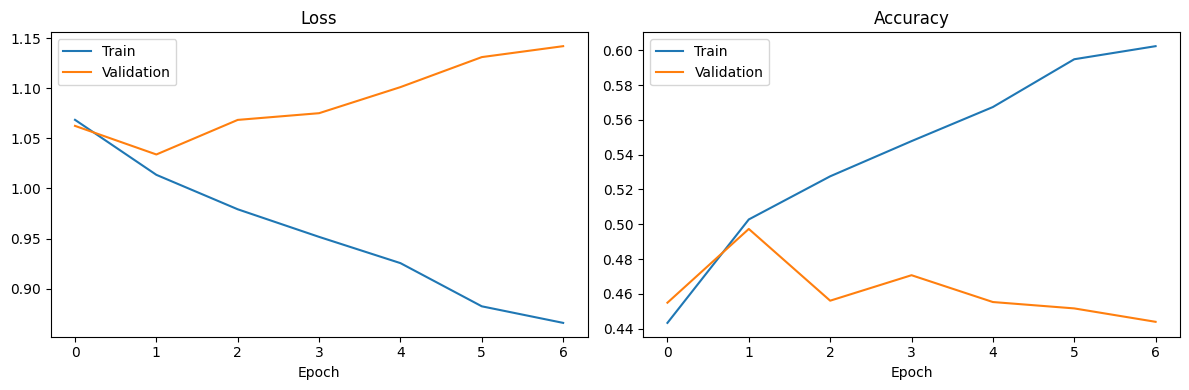

In [7]:
# ==============================================================================
# TRAINING HISTORY PLOT
# ==============================================================================

if model.history:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss
    axes[0].plot(model.history['train_loss'], label='Train')
    if model.history['val_loss']:
        axes[0].plot(model.history['val_loss'], label='Validation')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    
    # Accuracy
    axes[1].plot(model.history['train_acc'], label='Train')
    if model.history['val_acc']:
        axes[1].plot(model.history['val_acc'], label='Validation')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('tcn_attention_training_history.png', dpi=150)
    plt.show()

In [8]:
# ==============================================================================
# SAVE MODEL
# ==============================================================================

print("\n" + "="*60)
print("💾 SAVING MODEL")
print("="*60)

Path(MODEL_DIR).mkdir(exist_ok=True)
model.save(MODEL_DIR, name=f'tcn_attention_h{HORIZON}')

print(f"\n✅ Model saved: {MODEL_DIR}/tcn_attention_h{HORIZON}_model.keras")


💾 SAVING MODEL
✅ Model saved to models_artifacts

✅ Model saved: models_artifacts/tcn_attention_h1_model.keras


In [9]:
# ==============================================================================
# SUMMARY
# ==============================================================================

print("\n" + "="*60)
print("📋 SUMMARY")
print("="*60)

print(f"""
Model: TCN-Attention
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Horizon: {HORIZON} bar(s)
• Lookback: {model.lookback} steps
• TCN Filters: {model.tcn_filters}
• Attention Heads: {model.attention_heads}

Results:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Accuracy:    {metrics['accuracy']:.4f}
• F1 Weighted: {metrics['f1_weighted']:.4f}
• F1 Macro:    {metrics['f1_macro']:.4f}

Next: Run 05_comparison to see full model comparison.
""")


📋 SUMMARY

Model: TCN-Attention
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Horizon: 1 bar(s)
• Lookback: 32 steps
• TCN Filters: 64
• Attention Heads: 4

Results:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Accuracy:    0.5111
• F1 Weighted: 0.5030
• F1 Macro:    0.4832

Next: Run 05_comparison to see full model comparison.

